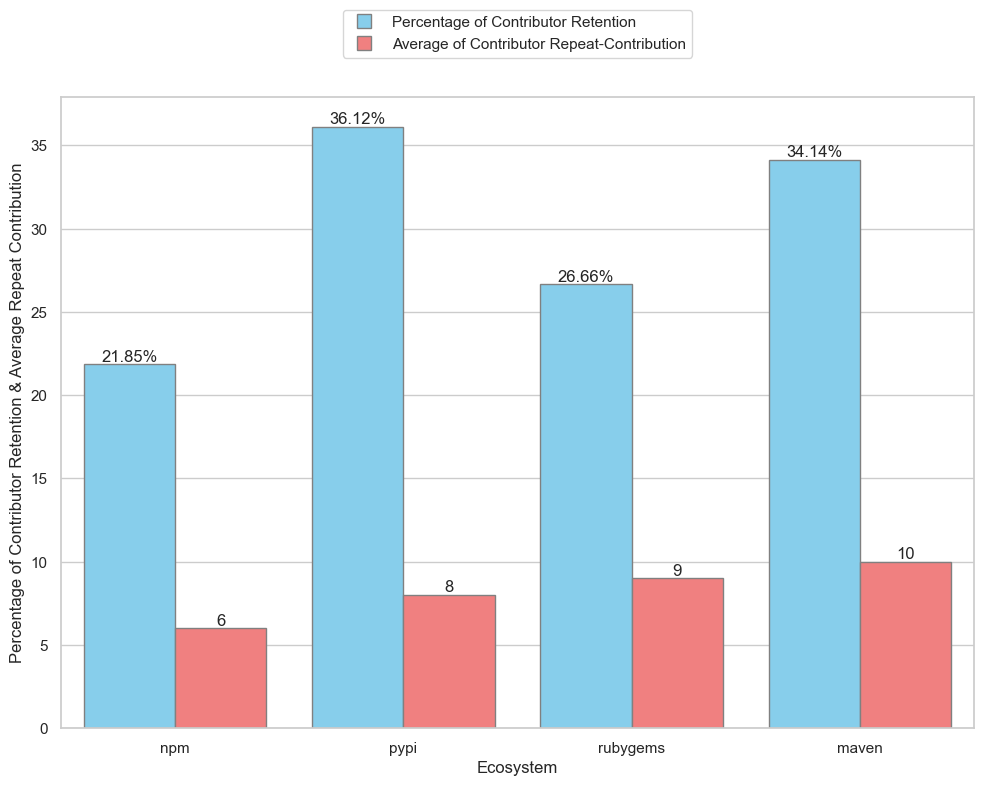

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv('community_engagement_records.csv')
df['datetime_created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='datetime_created_at', ascending=False)
df = df[~df['userlogin'].str.contains('Bot|bot', case=False)]
df['modified_userlogin'] = df['Name'] + '-' + df['ecosystem'] + '-' + df['userlogin']
filtered_data = df[~df['author_association'].isin(["COLLABORATOR", "MEMBER", "OWNER"])]
filtered_data = filtered_data[filtered_data['usertype'].isin(["User"])]

# Calculate metrics
ecosystem_results = {}
for ecosystem, group in filtered_data.groupby('ecosystem'):
    total_unique_contributors = 0
    contributors_with_more_than_1_prs = 0
    total_prs_by_contributors_with_more_than_1_prs = 0
    
    for name, group in group.groupby(['modified_userlogin']):
        total_unique_contributors += 1
        pr_count = len(group)
        if pr_count > 1:
            contributors_with_more_than_1_prs += 1
            total_prs_by_contributors_with_more_than_1_prs += pr_count
    
    percentage_with_subsequent_prs = (contributors_with_more_than_1_prs / total_unique_contributors) * 100
    average_subsequent_prs =  total_prs_by_contributors_with_more_than_1_prs / contributors_with_more_than_1_prs if contributors_with_more_than_1_prs > 0 else 0
    
    ecosystem_results[ecosystem] = {
        "PercentageWithSubsequentPRs": percentage_with_subsequent_prs,
        "AverageSubsequentPRs": int(round(average_subsequent_prs))
    }

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(ecosystem_results, orient='index')

# Reorder the rows in the DataFrame based on the desired order
results_df = results_df.reindex(['npm', 'pypi', 'rubygems', 'maven'])

# Plot using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Melt DataFrame for better visualization
melted_results_df = results_df.reset_index().melt(id_vars='index', value_vars=['PercentageWithSubsequentPRs', 'AverageSubsequentPRs'])
melted_results_df.columns = ['Ecosystem', 'Metric', 'Value']

# Plot and get the colors of the bars
ax = sns.barplot(data=melted_results_df, x='Ecosystem', y='Value', hue='Metric')

# Assigning colors to bars based on metrics
for bar, metric, value in zip(ax.patches, melted_results_df['Metric'], melted_results_df['Value']):
    if metric == 'PercentageWithSubsequentPRs':
        bar.set_facecolor('skyblue')
        # Adding value text to the top of each bar with '%'
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}%', ha='center', va='bottom')
    elif metric == 'AverageSubsequentPRs':
        bar.set_facecolor('lightcoral')
        # Adding integer value text to the top of each bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(value)}', ha='center', va='bottom')
    bar.set_edgecolor('gray')  # Assigning border color to bars

# Custom legend with desired colors
legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', markeredgecolor='gray', markersize=10, label=''),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markeredgecolor='gray', markersize=10, label='')]
plt.legend(handles=legend_elements, title='', labels=['Percentage of Contributor Retention', 'Average of Contributor Repeat-Contribution'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=1)

plt.xlabel('Ecosystem')
plt.ylabel('Percentage of Contributor Retention & Average Repeat Contribution')

plt.tight_layout()
plt.show()
